In [18]:
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.ops import unary_union

In [2]:
shp_path = "data/UKR_adm1.shp"

In [3]:
df = gpd.read_file(shp_path)
df.head()

,ID_0,ISO,NAME_0,ID_1,NAME_1,HASC_1,CCN_1,CCA_1,TYPE_1,ENGTYPE_1,NL_NAME_1,VARNAME_1,geometry
0,240,UKR,Ukraine,1,Cherkasy,UA.CK,0,None,Oblast',Region,None,Cherkas'ka Oblast'|Cherkasskaya Oblast'|Cherkassy,"POLYGON ((32.15047 50.19769, 32.15050 50.19181..."
1,240,UKR,Ukraine,2,Chernihiv,UA.CH,0,None,Oblast',Region,None,Chernigov|Tschernigow,"POLYGON ((33.19667 52.37500, 33.20612 52.36700..."
2,240,UKR,Ukraine,3,Chernivtsi,UA.CV,0,None,Oblast',Region,None,Chernivets'ka Oblast'|Chernovitskaya Oblast'|C...,"POLYGON ((25.62595 48.67673, 25.64460 48.67159..."
3,240,UKR,Ukraine,4,Crimea,UA.KR,0,None,Autonomous Republic,Autonomous Republic,None,Crimée|Criméia|Krim|Krymskaya Respublika|Respu...,"MULTIPOLYGON (((33.79458 44.39153, 33.79291 44..."
4,240,UKR,Ukraine,5,Dnipropetrovs'k,UA.DP,0,None,Oblast',Region,None,Dnipropetrovsk|Dniepropietrovsk|Dnjepropetrowsk,"POLYGON ((34.92995 49.15574, 34.92076 49.14992..."


In [4]:
# list of already existing warehouses
warehouses = ["L'viv", "Kiev", 'Kherson']

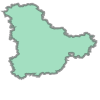

In [5]:
# there is a separate polygon shape fot Kiev city, excluded from its region
# merge them into one region and remove the city
merged_kiev = unary_union(df[df['NAME_1'].isin(['Kiev', 'Kiev City'])]['geometry'])
df = df.drop(df[df['NAME_1'] == 'Kiev City'].index)
df.loc[df['NAME_1'] == 'Kiev', 'geometry'] = merged_kiev
merged_kiev

<AxesSubplot: >

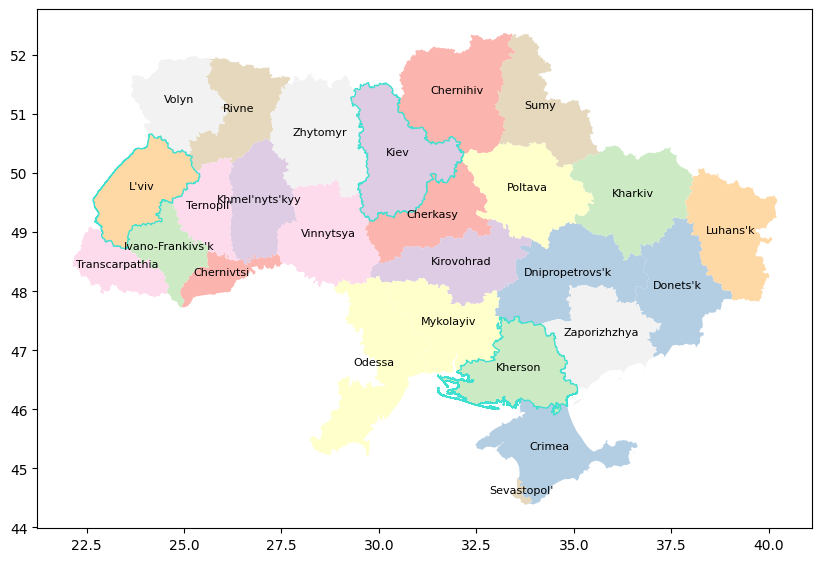

In [20]:
ax = df.plot(cmap='Pastel1', figsize=(10, 10))

# add regions names into the center of each shape
df.apply(lambda x: plt.annotate(text=x['NAME_1'], xy=x.geometry.centroid.coords[0], ha='center', fontsize=8), axis=1)

# highlight the existing warehouses with a balder outline
df.loc[df['NAME_1'].isin(warehouses)].plot(ax=ax, facecolor='none', edgecolor='turquoise', linewidth=1)